In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

import btrdb
from btrdb.utils.timez import ns_delta, ns_to_datetime, to_nanoseconds

import yaml

In [2]:
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)
    
#Establishing the connecting to the server
db = btrdb.connect(config['connection']['api_url'], apikey=config['connection']['api_key'])


In [3]:
#Choosing streams; we are choosing PMU3 here.
streams = db.streams_in_collection('sunshine/PMU3', tags={'unit': 'volts'})
base = 7.2e3

In [4]:
stream = streams[0]
start, _ = stream.earliest()
end, _ = stream.latest()

In [5]:
pw = 44 # or 2^38 nanoseconds

t0 = datetime.now()
points = streams[0].aligned_windows(start=start.time, end=end.time, pointwidth=pw)
dt = points[1][0].time - points[0][0].time


In [6]:
df = pd.DataFrame(columns=['time','min','max', 'mean','std'], index=range(len(points)))
for i, (p, _) in enumerate(points):
    df.loc[i] = [p.time, p.min/base, p.max/base, p.mean/base, p.stddev/base]
    

In [7]:
ns_to_datetime(df['time'].min())

datetime.datetime(2015, 7, 27, 23, 1, 3, 828697, tzinfo=<UTC>)

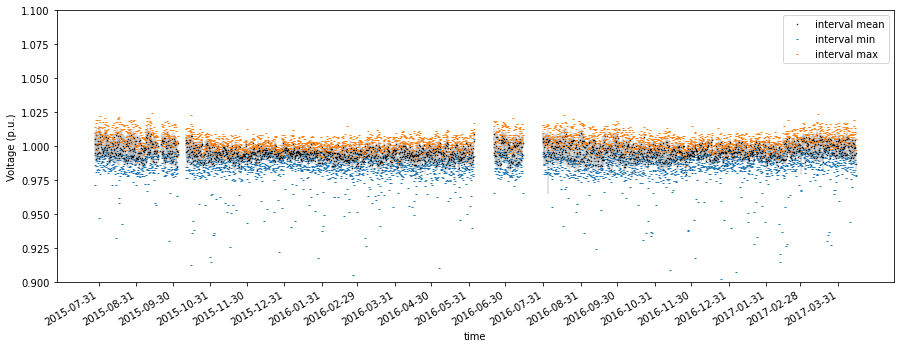

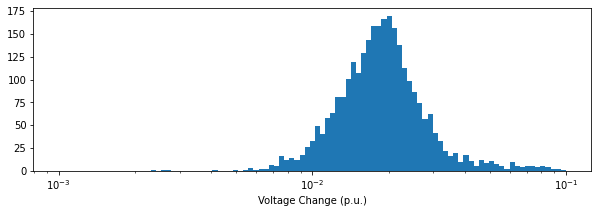

In [8]:
fig, ax = plt.subplots(figsize=(15,5))
ax.vlines(df['time'], df['mean']-df['std'], df['mean']+df['std'], alpha=0.5, color='0.7')
df.plot(x='time', y='mean', label='interval mean', ax=ax, ls=' ', marker='.', color='k', ms=1)
df.plot(x='time', y='min', label='interval min', ax=ax, ls=' ', marker='_', ms=2)
df.plot(x='time', y='max', label='interval max', ax=ax, ls=' ', marker='_', ms=2)
ax.set_ylim(0.9,1.1)
ax.set_ylabel('Voltage (p.u.)')

start_dt = ns_to_datetime(df['time'].min())
end_dt = ns_to_datetime(df['time'].max())
ticks = pd.date_range(start=datetime(start_dt.year,start_dt.month,1), 
                      end=datetime(end_dt.year,end_dt.month,1), freq='m')
ax.set_xticks([to_nanoseconds(t) for t in ticks])
ax.set_xticklabels([t.strftime('%Y-%m-%d') for t in ticks], rotation=30, ha='right')
plt.show()

fig, ax = plt.subplots(figsize=(10,3))
ax.hist(df['max']-df['min'], bins=np.logspace(-3,-1, 100))
ax.set_xlabel('Voltage Change (p.u.)')
ax.set_xscale('log')
plt.show()


In [46]:
pw = 38 # or 2^38 nanoseconds

t0 = datetime.now()
points = streams[0].aligned_windows(start=start.time, end=end.time, pointwidth=pw)
dt = points[1][0].time - points[0][0].time

print('pointwidth:\t%.2f minutes'%(dt/1e9/60))
print('statpoints:\t%i points'%(len(points)))

pointwidth:	4.58 minutes
statpoints:	184549 points


In [48]:
df = pd.DataFrame(columns=['time','min','max','mean','std', 'count'], index=range(len(points)))
for i, (p, _) in enumerate(points):
    df.loc[i] = [p.time, p.min/base, p.max/base, p.mean/base, p.stddev/base, p.count]

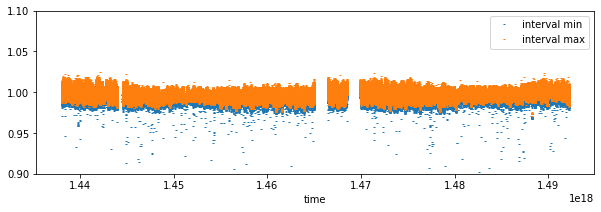

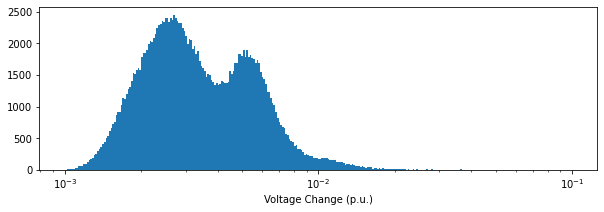

In [64]:
fig, ax = plt.subplots(figsize=(10,3))
df.plot(x='time', y='min', label='interval min', ax=ax, ls=' ', marker='_', ms=2)
df.plot(x='time', y='max', label='interval max', ax=ax, ls=' ', marker='_', ms=2)
ax.set_ylim(0.9,1.1)
plt.show()

fig, ax = plt.subplots(figsize=(10,3))
ax.hist(df['max']-df['min'], bins=np.logspace(-3,-1, 300))
ax.set_xlabel('Voltage Change (p.u.)')
ax.set_xscale('log')
plt.show()


In [123]:
from sklearn.mixture import GaussianMixture

n = 4
diff = (df['max'] - df['min']).astype(float).to_numpy()

X = np.log(diff).reshape((len(df),1))
gm = GaussianMixture(n_components=n, random_state=0, verbose=3).fit(X)

Initialization 0
  Iteration 10	 time lapse 0.83885s	 ll change 0.00147
Initialization converged: True	 time lapse 1.02796s	 ll -0.74260


In [124]:
np.vstack([gm.means_[:,0], gm.covariances_[:,0,0]])

array([[-5.65069334, -6.12823031, -5.28971559, -9.64019255],
       [ 0.11464168,  0.05895513,  0.21344832,  0.24525739]])

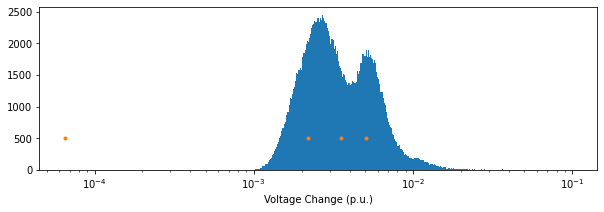

In [125]:
fig, ax = plt.subplots(figsize=(10,3))
ax.hist(diff, bins=np.logspace(-3,-1, 300))
ax.plot(np.exp(gm.means_[:,0]), [500 for ix in range(n)], ls=' ', marker='.')
ax.set_xlabel('Voltage Change (p.u.)')
ax.set_xscale('log')
plt.show()

In [ ]:
clusters = []
for i in range(n):
    clusters.append(np.exp(np.random.normal(gm.means_[i,0], gm.covariances_[i,0,0], int(1e8*gm.weights_[i,]))))
    print(i, len(clusters[-1]))

In [ ]:
fig, ax = plt.subplots()
bins = np.logspace(-3,-1, 300)
ax.set_xscale('log')
ax.hist(clusters[0], color='b', alpha=0.5, histtype='stepfilled', bins=bins)
ax.hist(clusters[1], color='g', alpha=0.5, histtype='stepfilled', bins=bins)
ax.hist(clusters[2], color='r', alpha=0.5, histtype='stepfilled', bins=bins)
plt.show()

In [104]:
diff.min()

2.0413928561738293e-05